# Goal
In this rapid times medical professionals wants to get the most accurate and efficient knowledge of diffeerent papers which were published from long ago. Due to such situation there are so many papers are there which we taken as dataset. There is more than 55000 pubished papers and articles inn different journals from all around the world. Our task iis to make clustering thing from which we can make best out of it and categories them in proper clusters.

In [6]:
import pandas as pd
import numpy as np

In [7]:
metaData = pd.read_csv('./data/metadata.csv', dtype={'pubmed_id': str, 'Microsoft academic paper id': str, 'doi': str})

In [8]:
# Checking null values
metaData.isna().sum()

cord_uid                           0
sha                            13374
source_x                           0
title                            158
doi                             3340
pmcid                           8746
pubmed_id                      14340
license                            0
abstract                        9230
publish_time                       8
authors                         2279
journal                         5242
Microsoft Academic Paper ID    51434
WHO #Covidence                 50630
has_pdf_parse                      0
has_pmc_xml_parse                  0
full_text_file                  8604
url                              302
dtype: int64

In [9]:
metaData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52398 entries, 0 to 52397
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   cord_uid                     52398 non-null  object 
 1   sha                          39024 non-null  object 
 2   source_x                     52398 non-null  object 
 3   title                        52240 non-null  object 
 4   doi                          49058 non-null  object 
 5   pmcid                        43652 non-null  object 
 6   pubmed_id                    38058 non-null  object 
 7   license                      52398 non-null  object 
 8   abstract                     43168 non-null  object 
 9   publish_time                 52390 non-null  object 
 10  authors                      50119 non-null  object 
 11  journal                      47156 non-null  object 
 12  Microsoft Academic Paper ID  964 non-null    float64
 13  WHO #Covidence  

In [10]:
import glob
folder = glob.glob('./data/biorxiv_medrxiv/biorxiv_medrxiv/pdf_json/*.json', recursive=True)
folder1 = glob.glob('./data/comm_use_subset/comm_use_subset/pdf_json/*.json', recursive=True)
folder2 = glob.glob('./data/comm_use_subset/comm_use_subset/pmc_json/*.json', recursive=True)
folder3 = glob.glob('./data/custom_license/custom_license/pdf_json/*.json', recursive=True)
folder4 = glob.glob('./data/custom_license/custom_license/pmc_json/*.json', recursive=True)
folder5 = glob.glob('./data/noncomm_use_subset/noncomm_use_subset/pdf_json/*.json', recursive=True)
folder6 = glob.glob('./data/noncomm_use_subset/noncomm_use_subset/pmc_json/*.json', recursive=True)

In [11]:
folder = folder1 + folder2 + folder3 + folder4 + folder5 + folder6
all_json = folder

In [12]:
import json
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            # Abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'
first_row = FileReader(all_json[0])

5e0c586f047ff909c8ed3fe171c8975a90608d08: Background: Porcine epidemic diarrhea virus (PEDV) is emerging as a pathogenic coronavirus that causes a huge economic burden to the swine industry. Interaction of the viral spike (S) surface glycopro... Porcine epidemic diarrhea virus (PEDV), which belongs to the Alphacoronavirus genus of the Coronaviridae family, is an etiological agent of porcine epidemic diarrhea (PED) and causes an enteric diseas...


In [13]:
def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0

    # add break every length characters
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data

In [14]:
dict_ = {'paper_id': [], 'doi': [], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}

In [15]:
meta_df = metaData
dict_ = {'paper_id': [], 'doi':[], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}
for idx, entry in enumerate(all_json):
    if idx % (len(all_json) // 10) == 0:
        print(f'Processing index: {idx} of {len(all_json)}')
    
    try:
        content = FileReader(entry)
    except Exception as e:
        continue  # invalid paper format, skip
    
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    # no metadata, skip this paper
    if len(meta_data) == 0:
        continue
    
    dict_['abstract'].append(content.abstract)
    dict_['paper_id'].append(content.paper_id)
    dict_['body_text'].append(content.body_text)
    
    # also create a column for the summary of abstract to be used in a plot
    if len(content.abstract) == 0: 
        # no abstract provided
        dict_['abstract_summary'].append("Not provided.")
    elif len(content.abstract.split(' ')) > 100:
        # abstract provided is too long for plot, take first 100 words append with ...
        info = content.abstract.split(' ')[:100]
        summary = get_breaks(' '.join(info), 40)
        dict_['abstract_summary'].append(summary + "...")
    else:
        # abstract is short enough
        summary = get_breaks(content.abstract, 40)
        dict_['abstract_summary'].append(summary)
        
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    
    try:
        # if more than one author
        authors = meta_data['authors'].values[0].split(';')
        if len(authors) > 2:
            # if more than 2 authors, take them all with html tag breaks in between
            dict_['authors'].append(get_breaks('. '.join(authors), 40))
        else:
            # authors will fit in plot
            dict_['authors'].append(". ".join(authors))
    except Exception as e:
        # if only one author - or Null valie
        dict_['authors'].append(meta_data['authors'].values[0])
    
    # add the title information, add breaks when needed
    try:
        title = get_breaks(meta_data['title'].values[0], 40)
        dict_['title'].append(title)
    # if title was not provided
    except Exception as e:
        dict_['title'].append(meta_data['title'].values[0])
    
    # add the journal information
    dict_['journal'].append(meta_data['journal'].values[0])
    
    # add doi
    dict_['doi'].append(meta_data['doi'].values[0])
    
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'doi', 'abstract', 'body_text', 'authors', 'title', 'journal', 'abstract_summary'])
df_covid.head()

Processing index: 0 of 58662
Processing index: 5866 of 58662
Processing index: 11732 of 58662
Processing index: 17598 of 58662
Processing index: 23464 of 58662
Processing index: 29330 of 58662
Processing index: 35196 of 58662
Processing index: 41062 of 58662
Processing index: 46928 of 58662
Processing index: 52794 of 58662
Processing index: 58660 of 58662


,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary
0,5e0c586f047ff909c8ed3fe171c8975a90608d08,10.1186/s12985-018-1042-3,Background: Porcine epidemic diarrhea virus (P...,"Porcine epidemic diarrhea virus (PEDV), which ...","Gong, Lang. Lin, Ying. Qin, Jianru. Li,<br...",Neutralizing antibodies against porcine<br>ep...,Virol J,Background: Porcine epidemic diarrhea virus<b...
1,1579fbff7af9b156c6f49fee0526e48f852ea460,10.1038/s41598-018-30356-2,"Currently, live-attenuated IBV vaccines are us...","Generation of rNDVs expressing S1, S2 or S pro...","Shirvani, Edris. Paldurai, Anandan. <br>Mano...",A Recombinant Newcastle Disease Virus (NDV)<b...,Sci Rep,"Currently, live-attenuated IBV vaccines are<b..."
2,e0668c4b793d0cad26639b070819334a94648123,10.3399/bjgpopen18x101493,,The incidence of complete Achilles tendon rupt...,"Mughal, Faraz. Chew-Graham, Carolyn A. Saad...",‘Hajj: what it means for general practice’,BJGP Open,Not provided.
3,38aa050ad79d8a1d7022c33535255ce9d47914e5,10.1371/journal.pntd.0002933,The new world arenavirus Junín virus (JUNV) is...,Arenaviruses are enveloped RNA viruses with bi...,"Huang, Cheng. Walker, Aida G.. Grant, Ashle...",Potent Inhibition of Junín Virus Infection by...,PLoS Negl Trop Dis,The new world arenavirus Junín virus (JUNV) i...
4,61722c462b054f36461375e96e502cbf22648c04,10.1038/s41598-019-45095-1,and subtropical countries and is a significant...,"In this study, the anti-dengue activity of nic...","Jung, Eunhye. Nam, Sangwoo. Oh, Hyeryeon. ...",Neutralization of Acidic Intracellular<br>Ves...,Sci Rep,and subtropical countries and is a significan...


In [16]:
df_covid['abstracrt_count'] = df_covid['abstract'].apply(lambda x: len(x.strip().split()))
df_covid['body_count'] = df_covid['body_text'].apply(lambda x: len(x.strip().split()))
df_covid['body_unique_words'] = df_covid['body_text'].apply(lambda x: len(set(str(x).split())))

In [17]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35023 entries, 0 to 35022
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   paper_id           35023 non-null  object
 1   doi                34685 non-null  object
 2   abstract           35023 non-null  object
 3   body_text          35023 non-null  object
 4   authors            34423 non-null  object
 5   title              34987 non-null  object
 6   journal            34854 non-null  object
 7   abstract_summary   35023 non-null  object
 8   abstracrt_count    35023 non-null  int64 
 9   body_count         35023 non-null  int64 
 10  body_unique_words  35023 non-null  int64 
dtypes: int64(3), object(8)
memory usage: 2.9+ MB


In [18]:
df_covid['abstract'].describe(include='all')

count     35023
unique    25126
top            
freq       9847
Name: abstract, dtype: object

In [19]:
df_covid.drop_duplicates(['abstract', 'body_text'], inplace=True)
df_covid['abstract'].describe(include='all')

count     35000
unique    25126
top            
freq       9835
Name: abstract, dtype: object

In [20]:
df_covid['body_text'].describe(include='all')

count                                                 35000
unique                                                34994
top       MIM 1,2 is a comprehensive knowledgebase of hu...
freq                                                      2
Name: body_text, dtype: object

In [21]:
df_covid.head()

,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary,abstracrt_count,body_count,body_unique_words
0,5e0c586f047ff909c8ed3fe171c8975a90608d08,10.1186/s12985-018-1042-3,Background: Porcine epidemic diarrhea virus (P...,"Porcine epidemic diarrhea virus (PEDV), which ...","Gong, Lang. Lin, Ying. Qin, Jianru. Li,<br...",Neutralizing antibodies against porcine<br>ep...,Virol J,Background: Porcine epidemic diarrhea virus<b...,211,3824,1310
1,1579fbff7af9b156c6f49fee0526e48f852ea460,10.1038/s41598-018-30356-2,"Currently, live-attenuated IBV vaccines are us...","Generation of rNDVs expressing S1, S2 or S pro...","Shirvani, Edris. Paldurai, Anandan. <br>Mano...",A Recombinant Newcastle Disease Virus (NDV)<b...,Sci Rep,"Currently, live-attenuated IBV vaccines are<b...",945,7372,1257
2,e0668c4b793d0cad26639b070819334a94648123,10.3399/bjgpopen18x101493,,The incidence of complete Achilles tendon rupt...,"Mughal, Faraz. Chew-Graham, Carolyn A. Saad...",‘Hajj: what it means for general practice’,BJGP Open,Not provided.,0,2972,1099
3,38aa050ad79d8a1d7022c33535255ce9d47914e5,10.1371/journal.pntd.0002933,The new world arenavirus Junín virus (JUNV) is...,Arenaviruses are enveloped RNA viruses with bi...,"Huang, Cheng. Walker, Aida G.. Grant, Ashle...",Potent Inhibition of Junín Virus Infection by...,PLoS Negl Trop Dis,The new world arenavirus Junín virus (JUNV) i...,160,3194,1096
4,61722c462b054f36461375e96e502cbf22648c04,10.1038/s41598-019-45095-1,and subtropical countries and is a significant...,"In this study, the anti-dengue activity of nic...","Jung, Eunhye. Nam, Sangwoo. Oh, Hyeryeon. ...",Neutralization of Acidic Intracellular<br>Ves...,Sci Rep,and subtropical countries and is a significan...,897,4095,1238


In [22]:
df_covid.describe()

,abstracrt_count,body_count,body_unique_words
count,35000.000000,35000.000000,35000.000000
mean,155.885857,4748.334543,1437.995229
std,157.350459,7035.270559,1187.604975
min,0.000000,1.000000,1.000000
25%,0.000000,2388.000000,909.000000
50%,155.000000,3678.000000,1250.000000
75%,233.000000,5499.000000,1694.000000
max,4767.000000,260378.000000,38298.000000


In [23]:
df = df_covid
del df_covid

In [24]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34023 entries, 0 to 35021
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   paper_id           34023 non-null  object
 1   doi                34023 non-null  object
 2   abstract           34023 non-null  object
 3   body_text          34023 non-null  object
 4   authors            34023 non-null  object
 5   title              34023 non-null  object
 6   journal            34023 non-null  object
 7   abstract_summary   34023 non-null  object
 8   abstracrt_count    34023 non-null  int64 
 9   body_count         34023 non-null  int64 
 10  body_unique_words  34023 non-null  int64 
dtypes: int64(3), object(8)
memory usage: 3.1+ MB


In [25]:
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

DetectorFactory.seed = 0

languages = []
for ii in tqdm(range(0, len(df))):
    text = df.iloc[ii]['body_text'].split(" ")
    lang = 'en'
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(' '.join(all_words))
        except Exception as e:
            try:
                lang = detect(df.iloc[ii]['abstract_summary'])
            except Exception as e:
                lang = 'unknown'
                pass
    languages.append(lang)

100%|██████████| 34023/34023 [03:19<00:00, 170.41it/s]


In [26]:
from pprint import pprint

languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
print(f'Total: {len(languages)}\n')
pprint(languages_dict)

Total: 34023

{'af': 1,
 'ca': 2,
 'cy': 4,
 'de': 111,
 'en': 33183,
 'es': 306,
 'fr': 345,
 'it': 15,
 'nl': 39,
 'pl': 2,
 'pt': 14,
 'zh-cn': 1}


In [27]:
# Papers distribution by their language
import matplotlib.pyplot as plt
df['languages'] = languages
dictLang = df['languages'].value_counts().to_dict()
keys = []
values = []
for key, value in dictLang.items():
    keys.append(key)
    values.append(value)

### As we can see significantly that most of the papers are published in english language.

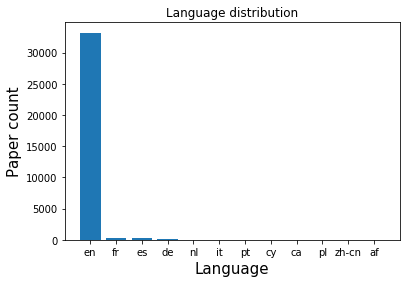

In [28]:
plt.bar(keys, values)
plt.title('Language distribution')
plt.xlabel('Language', fontsize = 15)
plt.ylabel('Paper count', fontsize = 15)
plt.show()

In [29]:
# For simplicity we are dropping all non-english papers
# We are dropping 840 papers.
dfEnglish = df[df['languages'] == 'en']

In [30]:
# Download spacy library.
# Spacy refernce: https://spacy.io
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_lg

In [31]:
# Stop words contain no meaning and due to that they create overhead while creating row vector. 
# So to remove them is one of the important step in text pre-precessing

In [32]:
print(f"There are total {len(STOP_WORDS)} stop words in this set.")

There are total 326 stop words in this set.


In [38]:
import string
punct = string.punctuation
stopWords = list(STOP_WORDS)
parser = en_core_web_lg.load(disable=["tagger", "ner"])
parser.max_length = 7000000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopWords and word not in punct ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [45]:
# We are taking only first 100 data because of very heavy data processing
dfEnglish = dfEnglish[:100]

In [40]:
tqdm.pandas()
dfEnglish["processed_text"] = dfEnglish["body_text"].progress_apply(spacy_tokenizer)

/Users/yashchoksi/anaconda3/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 100/100 [00:36<00:00,  2.76it/s]


In [41]:
import seaborn as sns

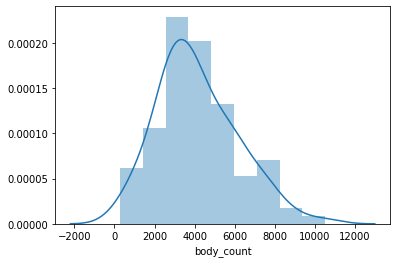

In [46]:
# Word count in papers after removing stop words
sns.distplot(dfEnglish['body_count'])

In [47]:
dfEnglish.head()

,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary,abstracrt_count,body_count,body_unique_words,languages,processed_text
0,5e0c586f047ff909c8ed3fe171c8975a90608d08,10.1186/s12985-018-1042-3,Background: Porcine epidemic diarrhea virus (P...,"Porcine epidemic diarrhea virus (PEDV), which ...","Gong, Lang. Lin, Ying. Qin, Jianru. Li,<br...",Neutralizing antibodies against porcine<br>ep...,Virol J,Background: Porcine epidemic diarrhea virus<b...,211,3824,1310,en,porcine epidemic diarrhea virus pedv belong al...
1,1579fbff7af9b156c6f49fee0526e48f852ea460,10.1038/s41598-018-30356-2,"Currently, live-attenuated IBV vaccines are us...","Generation of rNDVs expressing S1, S2 or S pro...","Shirvani, Edris. Paldurai, Anandan. <br>Mano...",A Recombinant Newcastle Disease Virus (NDV)<b...,Sci Rep,"Currently, live-attenuated IBV vaccines are<b...",945,7372,1257,en,generation rndvs express s1 s2 s protein ibv e...
2,e0668c4b793d0cad26639b070819334a94648123,10.3399/bjgpopen18x101493,,The incidence of complete Achilles tendon rupt...,"Mughal, Faraz. Chew-Graham, Carolyn A. Saad...",‘Hajj: what it means for general practice’,BJGP Open,Not provided.,0,2972,1099,en,incidence complete achilles tendon rupture 18 ...
3,38aa050ad79d8a1d7022c33535255ce9d47914e5,10.1371/journal.pntd.0002933,The new world arenavirus Junín virus (JUNV) is...,Arenaviruses are enveloped RNA viruses with bi...,"Huang, Cheng. Walker, Aida G.. Grant, Ashle...",Potent Inhibition of Junín Virus Infection by...,PLoS Negl Trop Dis,The new world arenavirus Junín virus (JUNV) i...,160,3194,1096,en,arenaviruses envelop rna virus bi segment nega...
4,61722c462b054f36461375e96e502cbf22648c04,10.1038/s41598-019-45095-1,and subtropical countries and is a significant...,"In this study, the anti-dengue activity of nic...","Jung, Eunhye. Nam, Sangwoo. Oh, Hyeryeon. ...",Neutralization of Acidic Intracellular<br>Ves...,Sci Rep,and subtropical countries and is a significan...,897,4095,1238,en,study anti dengue activity niclosamide evaluat...


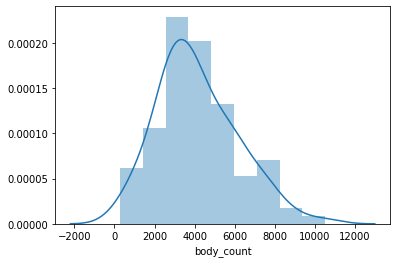

In [48]:
# Unique words
sns.distplot(dfEnglish['body_count'])

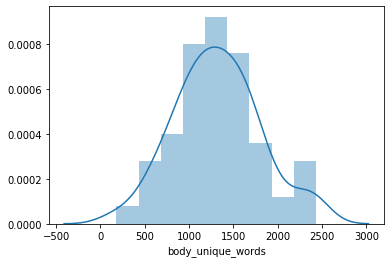

In [50]:
sns.distplot(dfEnglish['body_unique_words'])

In [51]:
# Create vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(data, maxFeature):
    vectorize = TfidfVectorizer(maxFeature)
    return vectorize.fit_transform(data)

In [52]:
text = dfEnglish['processed_text'].values
X = vectorize(text, 2 ** 12)
X.shape

(100, 17302)

In [53]:
# We have to remove some of the data and reducee some dimensions
from sklearn.decomposition import PCA
# We have tp select some components and random state will be tuned according to the time and cores
# As you increase the number of cores it will take some more time painfully, there is more chance that 
# it will take hours
pca = PCA(n_components=0.95, random_state= 42)
xReduce = pca.fit_transform(X.toarray())
xReduce.shape

(100, 90)

In [54]:
# Now we enters in the final stage of our NLP project 
# We are going to build classification model using KMeans

In [56]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

In [58]:
distortions = []
K = range(2, 50)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42, n_jobs=-1).fit(xReduce)
    k_means.fit(xReduce)
    distortions.append(sum(np.min(cdist(xReduce, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    #print('Found distortion for {} clusters'.format(k))

In [60]:
# run kmeans with many different k
distortions = []
K = range(2, 50)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42, n_jobs=-1).fit(xReduce)
    k_means.fit(xReduce)
    distortions.append(sum(np.min(cdist(xReduce, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    #print('Found distortion for {} clusters'.format(k))

In [63]:
k = 20
kmeans = KMeans(n_clusters=k, random_state=42, n_jobs=-1)
y_pred = kmeans.fit_predict(xReduce)
dfEnglish['y'] = y_pred

In [65]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=100, random_state=42)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 99 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.001s...
[t-SNE] Computed neighbors for 100 samples in 0.029s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 41.828728
[t-SNE] KL divergence after 400 iterations: 0.000001


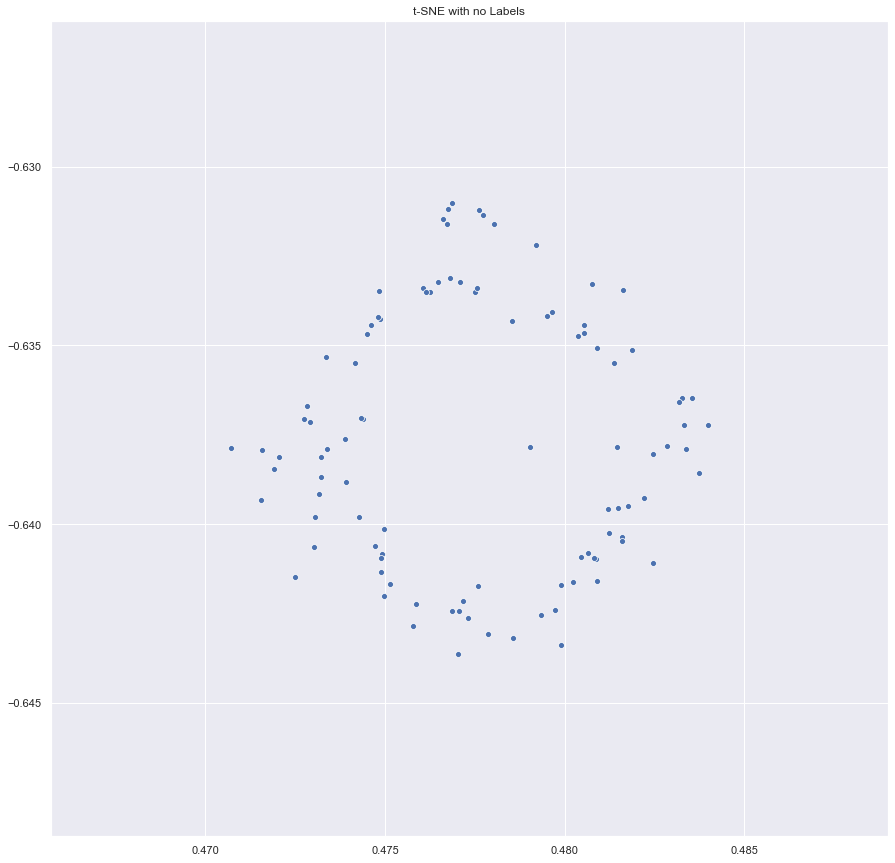

In [67]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)
plt.title('t-SNE with no Labels')
plt.savefig("./t-sne_covid19.png")
plt.show()

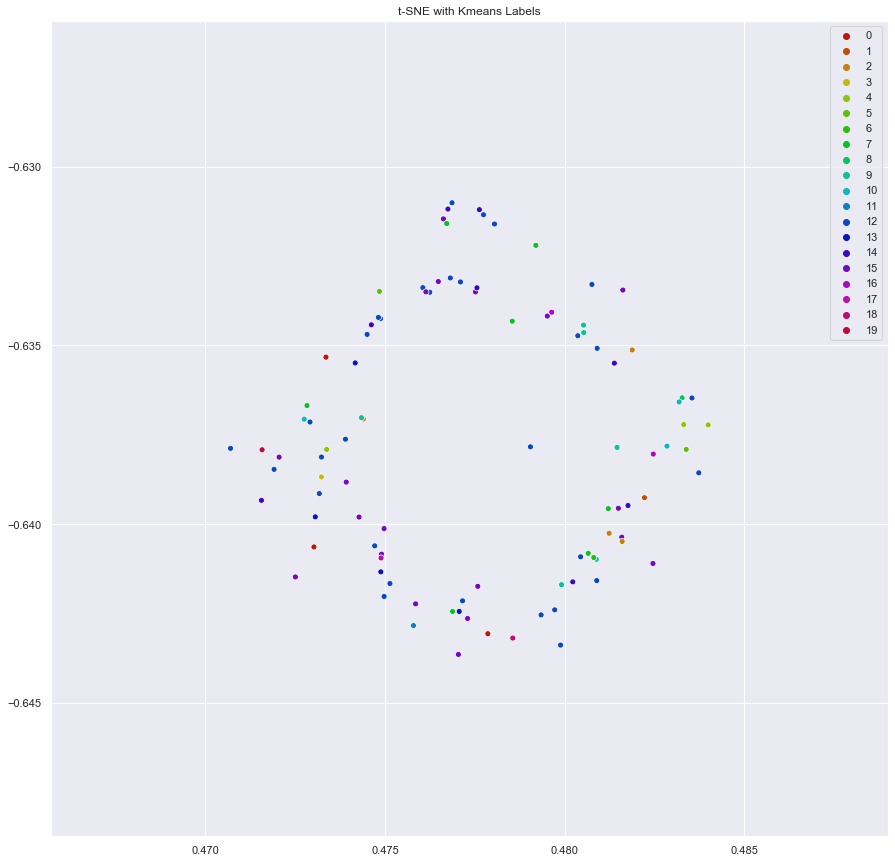

In [69]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15, 15)})

# colors
palette = sns.hls_palette(20, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("./improved_cluster_tsne.png")
plt.show()